# **Image Classification Model Deployment**

## Profile

**Achmad Hadi Kurnia**

Link [Dicoding](https://www.dicoding.com/users/achmadhadikurnia)

## Kriteria
- [x] Dataset yang akan dipakai bebas, namun minimal memiliki 1000 buah gambar.
- [x] Dataset tidak pernah digunakan pada submission kelas machine learning sebelumnya.
- [x] Dataset dibagi menjadi 80% train set dan 20% test set.
- [x] Model harus menggunakan model sequential.
- [x] Model harus menggunakan Conv2D Maxpooling Layer.
- [x] Akurasi pada training dan validation set minimal sebesar 80%.
- [x] Menggunakan Callback.
- [x] Membuat plot terhadap akurasi dan loss model.
- [x] Menulis kode untuk menyimpan model ke dalam format TF-Lite.

## Saran untuk Penilaian Lebih Tinggi
- [x] Dataset yang digunakan berisi lebih dari 2000 gambar.
- [x] Mengimplementasikan Callback.
- [x] Gambar-gambar pada dataset memiliki resolusi yang tidak seragam.

### 1. Setup Kebutuhan

In [1]:
# Installing packages
print('\nInstalling packages')
!pip install -q kaggle
!pip install split-folders

# Impor libary
import os
import zipfile
import tensorflow as tf
import splitfolders as sf
import matplotlib.pyplot as plt

from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from PIL import Image

%matplotlib inline

# Upload credential
print('\nUpload credential')
credential = files.upload()
!chmod 600 /content/kaggle.json

# Prepare dataset
print('\nDownloading dataset')
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d duttadebadri/image-classification
localZip = 'image-classification.zip'
zipRef = zipfile.ZipFile(localZip, 'r')
zipRef.extractall('image-classification')
zipRef.close()


Installing packages

Upload credential


Saving kaggle.json to kaggle.json

100% 2.34G/2.34G [01:29<00:00, 32.7MB/s]
100% 2.34G/2.34G [01:29<00:00, 28.0MB/s]


### 2. Menyiapkan data

In [3]:
dataset_path = 'image-classification/images/images'

def delete_non_jpg_empty_files(directory_path):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file)

            if (not file.lower().endswith('.jpg')) or (os.path.getsize(file_path) == 0):
                print(f"Deleting {file_path} as it's not a .jpg file or it's empty")
                os.remove(file_path)

print('Deleting non .jpg files')
delete_non_jpg_empty_files(dataset_path)

def list_dirs_and_files(directory_path):
    print('Folder and its number of files:')

    folders = [folder for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]
    total_files = 0
    total_folders = len(folders)

    for folder in folders:
        folder_path = os.path.join(directory_path, folder)
        files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]
        file_count = len(files)
        total_files += file_count
        print(f"{folder} [{file_count}] files")

    print(f"\nTotal files in all folders: {total_files}")
    print(f"Total folders (label): {total_folders}")

print('\nDirectory dataset info')
list_dirs_and_files(dataset_path)

def list_various_resolutions(directory):
    folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    image_sizes = []

    for folder in folders:
        folder_path = os.path.join(directory, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                with Image.open(file_path) as image:
                    width, height = image.size
                    image_sizes.append(f'{width}x{height}')

    unique_sizes = set(image_sizes)
    first_size_unique = 8

    print(f'Size all images: {len(image_sizes)}')
    print(f'Size unique images: {len(unique_sizes)}')
    print(f'First {first_size_unique} unique images: {list(unique_sizes)[:first_size_unique]}')

print('\nList various resolutions')
list_various_resolutions(dataset_path)

Deleting non .jpg files

Directory dataset info
Folder and its number of files:
travel and  adventure [8800] files
architecure [8763] files
art and culture [7570] files
food and d rinks [6744] files

Total files in all folders: 31877
Total folders (label): 4

List various resolutions
Size all images: 31877
Size unique images: 4400
First 8 unique images: ['550x410', '940x622', '1023x681', '784x1210', '1466x868', '1000x200', '290x414', '570x191']


In [4]:
image_dir = os.path.join('image-classification/image')

sf.ratio(
    dataset_path,
    output = image_dir,
    seed = None,
    ratio = (0.8, 0.2),
)

Copying files: 31877 files [00:14, 2200.43 files/s]


### 3. Modeling

In [8]:
train_dir = image_dir+'/train'
val_dir = image_dir+'/val'
label_size = len(os.listdir(val_dir))

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2,
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 64,
    shuffle = True,
    color_mode = 'rgb',
    class_mode = 'categorical',
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = 64,
    shuffle = True,
    color_mode = 'rgb',
    class_mode = 'categorical',
)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(label_size, activation='softmax'),
])

learning_rate=0.001
optimizer = 'adam'
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy'],
)

print('\nModel summary')
model.summary()

class accuracyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92:
            print("\nAccuracy has reached 92%!")
            self.model.stop_training = True

callbacks = accuracyThresholdCallback()

print('\nTraining process')
epoch_number = 64
history = model.fit(
    train_gen,
    epochs = epoch_number,
    steps_per_epoch = 16,
    validation_data = val_gen,
    validation_steps = 16,
    callbacks = [callbacks],
    verbose = 2,
)

Found 25501 images belonging to 4 classes.
Found 6376 images belonging to 4 classes.

Model summary
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                    

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


16/16 - 7s - loss: 0.9843 - accuracy: 0.5732 - val_loss: 0.9390 - val_accuracy: 0.5996 - 7s/epoch - 420ms/step
Epoch 8/64
16/16 - 8s - loss: 0.9051 - accuracy: 0.6094 - val_loss: 0.9269 - val_accuracy: 0.6045 - 8s/epoch - 519ms/step
Epoch 9/64
16/16 - 6s - loss: 0.8634 - accuracy: 0.6455 - val_loss: 0.9371 - val_accuracy: 0.6025 - 6s/epoch - 403ms/step
Epoch 10/64
16/16 - 7s - loss: 0.8349 - accuracy: 0.6533 - val_loss: 0.7598 - val_accuracy: 0.7080 - 7s/epoch - 468ms/step
Epoch 11/64
16/16 - 9s - loss: 0.8440 - accuracy: 0.6738 - val_loss: 0.7368 - val_accuracy: 0.7451 - 9s/epoch - 544ms/step
Epoch 12/64
16/16 - 7s - loss: 0.7907 - accuracy: 0.6846 - val_loss: 0.7873 - val_accuracy: 0.6748 - 7s/epoch - 434ms/step
Epoch 13/64
16/16 - 8s - loss: 0.7115 - accuracy: 0.7119 - val_loss: 0.7917 - val_accuracy: 0.6748 - 8s/epoch - 513ms/step
Epoch 14/64
16/16 - 8s - loss: 0.7217 - accuracy: 0.7471 - val_loss: 0.6260 - val_accuracy: 0.7568 - 8s/epoch - 508ms/step
Epoch 15/64
16/16 - 9s - loss:

## 4. Plot

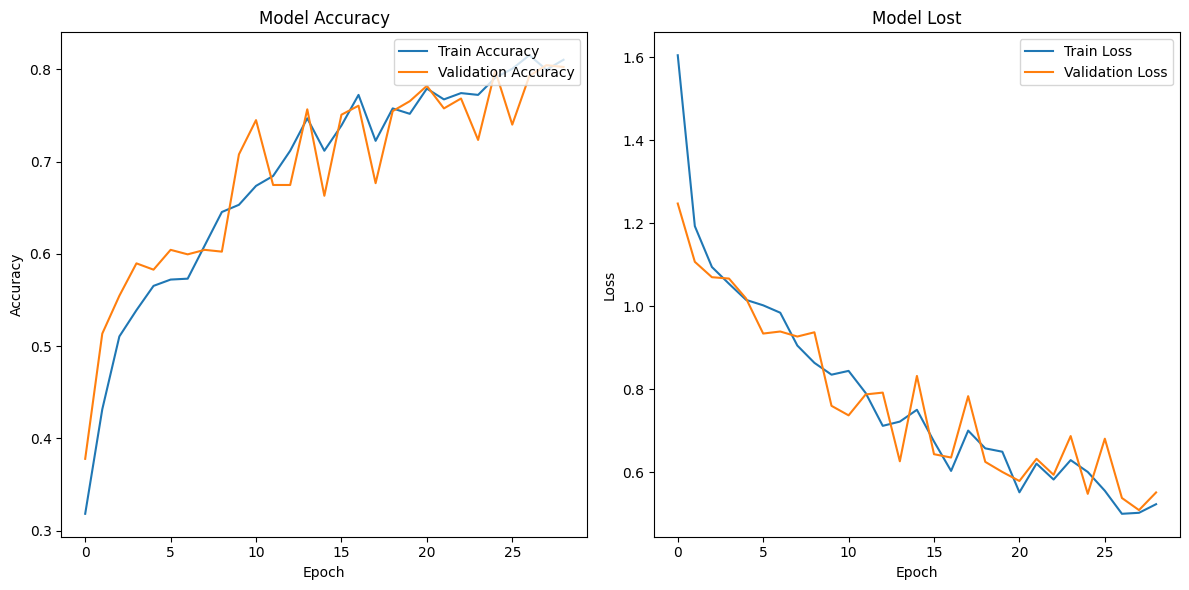

In [9]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy
axes[0].plot(train_accuracy, label='Train Accuracy')
axes[0].plot(val_accuracy, label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='upper right')

# Plot loss
axes[1].plot(train_loss, label='Train Loss')
axes[1].plot(val_loss, label='Validation Loss')
axes[1].set_title('Model Lost')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

## **Convert to TFLite**

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile("model.tflite", "wb") as f:
  f.write(tflite_model)